# disp-mask visualization
- Update `INPUT_CSV` to point to your data file
- Run all cells to generate and display the plot, and save the svg output


In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

BASE_FONT_SIZE = 16
PAD_SCALE = 12 / BASE_FONT_SIZE
LABEL_BBOX_PAD = 0.1 * PAD_SCALE
TICK_BBOX_PAD = 0.35 * PAD_SCALE
TOP_MARGIN = max(0.80, 0.90 - (1 - PAD_SCALE) * 0.08)
LEGEND_Y = 0.88

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': BASE_FONT_SIZE,
    'axes.linewidth': 1.2,
    'axes.labelsize': BASE_FONT_SIZE,
    'xtick.labelsize': BASE_FONT_SIZE,
    'ytick.labelsize': BASE_FONT_SIZE,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'legend.fontsize': BASE_FONT_SIZE,
    'axes.grid': False,
    'figure.figsize': (8, 4),
    'figure.constrained_layout.use': False
})


In [2]:

# change the csv path
INPUT_CSV = r'./Ruijin/008/_00_00_45.csv'
OUTPUT_DIR = r'./'

COLORS = {
    'gt': '#18212bff',
    'mask': '#3498db',
}

LINEWIDTHS = {
    'long_gt': 1.2,
    'long_disc_mask': 1.2,
}

ALPHAS = {
    'mask_bg': 0.45,
    'disc_mask': 0.45,
    'gt': 0.75,
}

PARAMS = {
    'long_mask_thresh': 20,
    'sample_rate': 50,
    'mask_ratio': 0.1,
}

In [3]:
def load_first_column(csv_path):
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 1:
        return np.array([])
    col0 = pd.to_numeric(df.iloc[:, 0], errors='coerce')
    col0 = col0.dropna()
    return col0.values.flatten()


def make_mask(seq_len, mask_ratio=0.1):
    if seq_len <= 0:
        return np.array([], dtype=bool)

    discrete_ratio = mask_ratio / 3
    disc_mask = np.random.rand(seq_len) < discrete_ratio
    cont_mask = np.zeros(seq_len, dtype=bool)
    mask_len = max(1, int(seq_len * mask_ratio))
    start = np.random.randint(0, seq_len - mask_len + 1)
    cont_mask[start:start + mask_len] = True
    return cont_mask, disc_mask


def classify_masks_from_mask(mask, min_continuous_len=20):
    mask = mask.astype(bool)
    bounded = np.concatenate(([0], mask.astype(int), [0]))
    diffs = np.diff(bounded)
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]
    intervals = list(zip(starts, ends))

    continuous_regions = []
    discrete_indices = []

    for start, end in intervals:
        length = end - start
        if length >= min_continuous_len:
            continuous_regions.append((start, end))
        else:
            discrete_indices.extend(range(start, end))

    return continuous_regions, discrete_indices


Saving to: ./disp-mask__00_00_45.svg


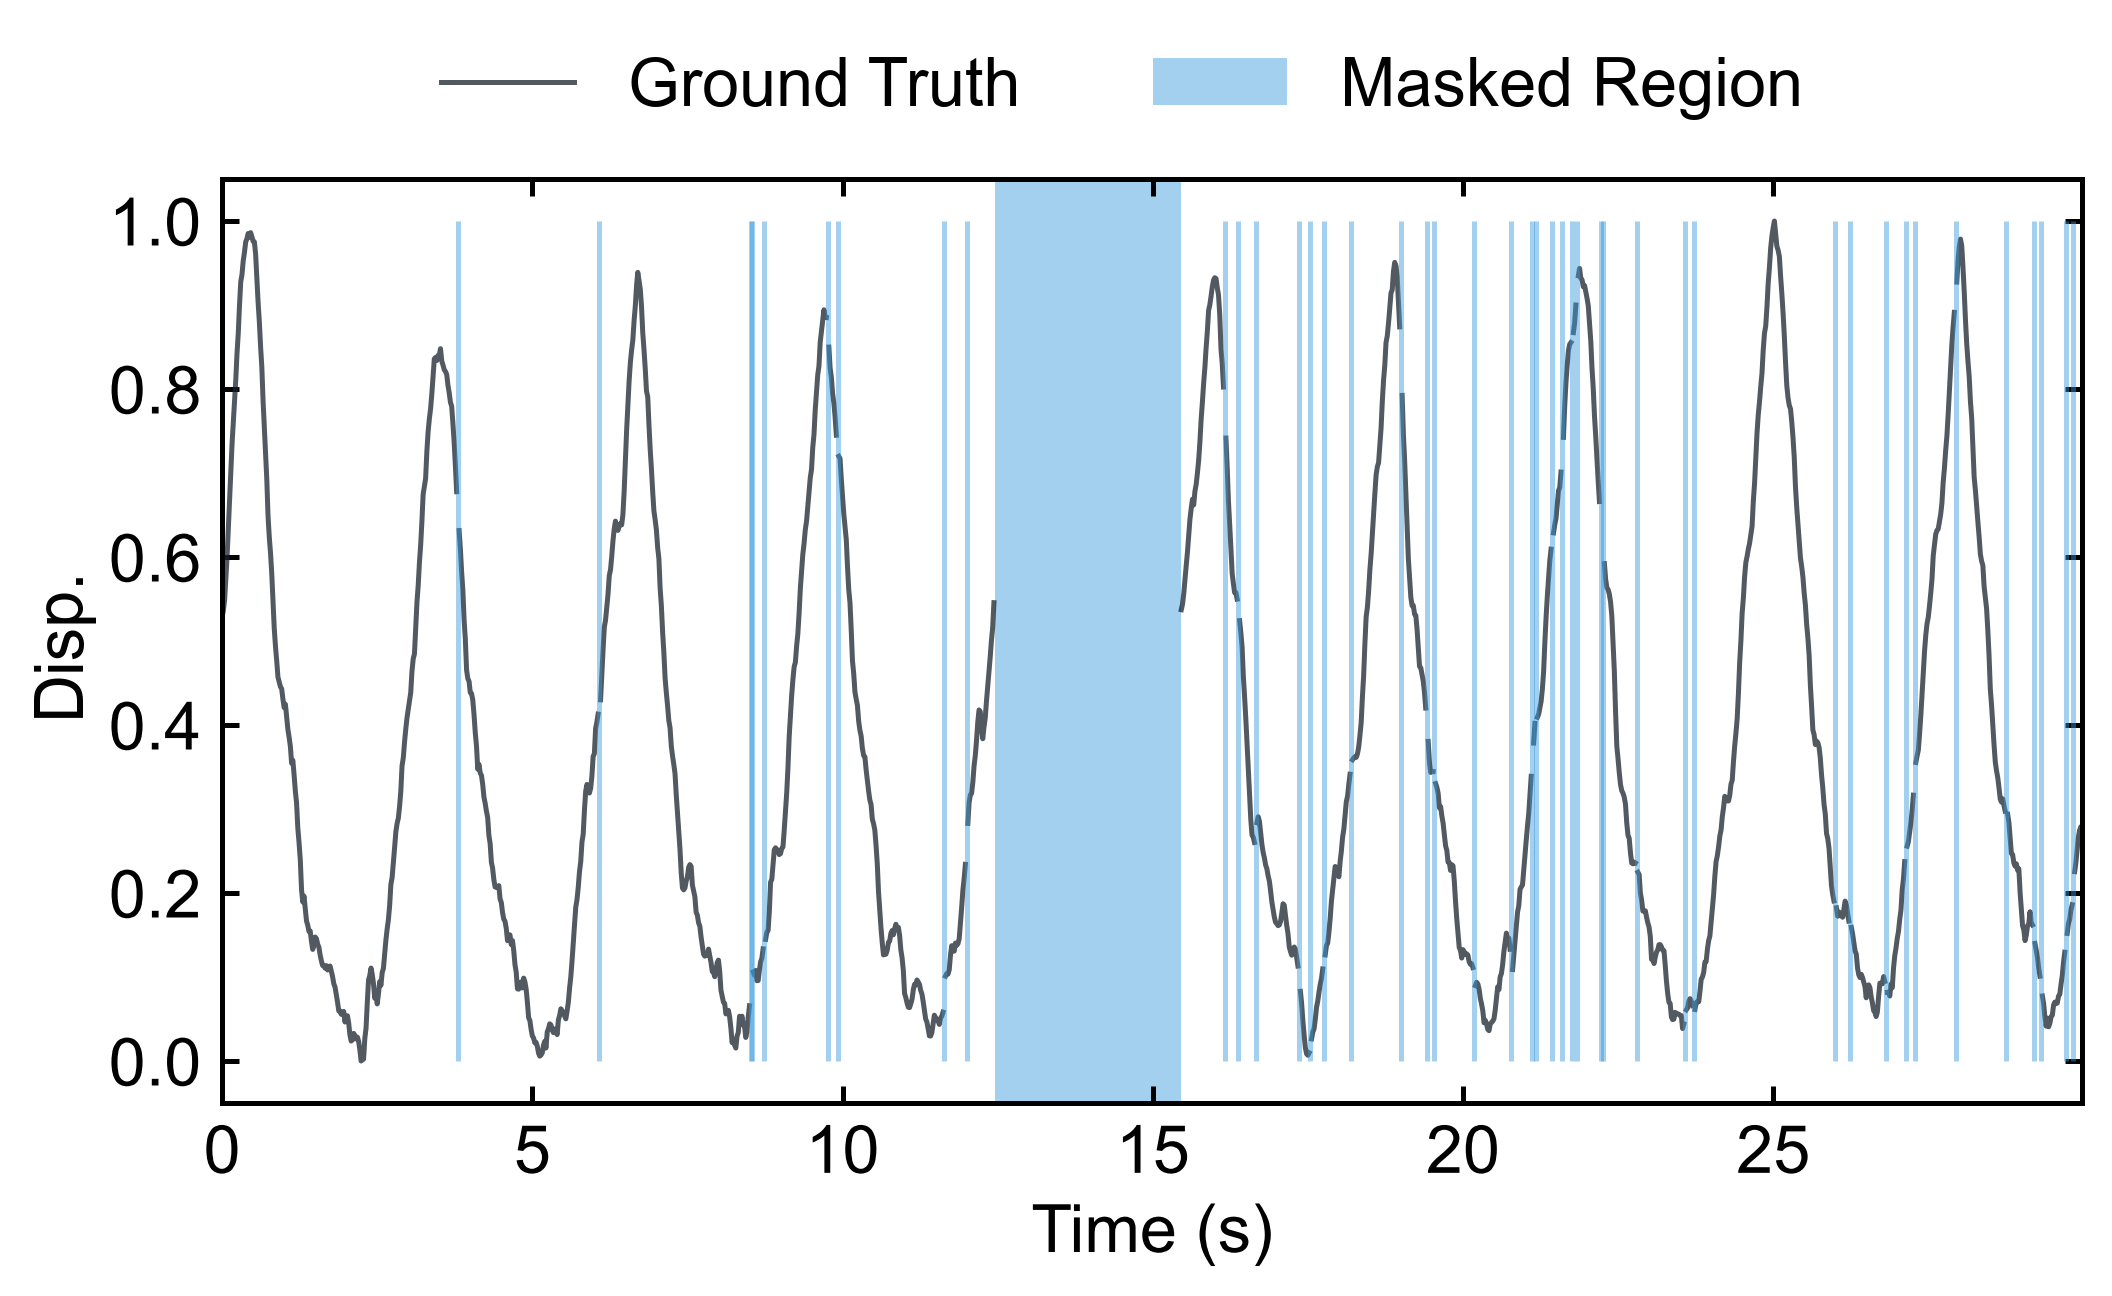

In [4]:
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f'Input csv not found: {INPUT_CSV}')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

l_orig = load_first_column(INPUT_CSV)
if len(l_orig) == 0:
    raise ValueError('Input csv is empty or has no valid data in first column.')

cont_mask, disc_mask = make_mask(len(l_orig), mask_ratio=PARAMS['mask_ratio'])
mask = cont_mask | disc_mask
cont_regions, _ = classify_masks_from_mask(cont_mask, min_continuous_len=PARAMS['long_mask_thresh'])

disc_plot = disc_mask & ~cont_mask
_, disc_indices = classify_masks_from_mask(disc_plot, min_continuous_len=PARAMS['long_mask_thresh'])

sr = PARAMS['sample_rate']
l_time = np.arange(len(l_orig)) / sr
l_masked = l_orig.copy()
l_masked[mask] = np.nan

fig, ax = plt.subplots(1, 1, dpi=300)
plt.subplots_adjust(top=TOP_MARGIN)

ax.plot(l_time, l_masked, color=COLORS['gt'], linewidth=LINEWIDTHS['long_gt'],
        alpha=ALPHAS['gt'], label='Ground Truth')

for i, (start, end) in enumerate(cont_regions):
    lbl = 'Masked Region' if i == 0 else None
    ax.axvspan(start / sr, end / sr, color=COLORS['mask'], alpha=ALPHAS['mask_bg'], lw=0, label=lbl)

if len(disc_indices) > 0:
    ax.vlines(np.array(disc_indices) / sr, ymin=np.min(l_orig), ymax=np.max(l_orig),
              colors=COLORS['mask'], linewidth=LINEWIDTHS['long_disc_mask'],
              alpha=ALPHAS['disc_mask'])

ax.set_xlim(l_time[0], l_time[-1])
ax.set_xlabel('Time (s)', fontweight='normal')
ax.set_ylabel('Disp.', fontweight='normal')

x_lbl = ax.xaxis.label
x_lbl.set_bbox(dict(facecolor='white', edgecolor='none', pad=LABEL_BBOX_PAD, alpha=1.0))
x_lbl.set_zorder(10)
x_lbl.set_path_effects([pe.withStroke(linewidth=3, foreground='white')])

ax.tick_params(axis='both', direction='in', top=True, right=True, length=4, width=1.2, zorder=4, pad=5)
for spine in ax.spines.values():
    spine.set_zorder(3)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_bbox(dict(facecolor='white', edgecolor='white', boxstyle=f'square,pad={TICK_BBOX_PAD:.3f}'))
    lbl.set_zorder(7)
    lbl.set_path_effects([pe.withStroke(linewidth=1, foreground='white')])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, LEGEND_Y),
           ncol=2, frameon=False, fontsize=BASE_FONT_SIZE)

base_name = os.path.splitext(os.path.basename(INPUT_CSV))[0]
output_name = f'disp-mask_{base_name}.svg'
output_path = os.path.join(OUTPUT_DIR, output_name)

print(f'Saving to: {output_path}')
plt.savefig(output_path, format='svg', bbox_inches='tight')
plt.show()
